In [1]:
import json
import time
import webcolors
import cv2
import matlab.engine
import networkx as nx
import sys
sys.path.append("../../")
import pandas as pd
import webcolors
import numpy as np
import os
import math
import cv2
import matplotlib.pyplot as plt
import pickle
import argparse
import constants
from VisualizerWrapper import Visualizer

from scipy.interpolate import interp1d
from tqdm import tqdm
from skimage import measure
from glob import glob

from core.graph_generation import visualization as visualizer
from core.utils.module import Node, VesselSegment
from PIL import Image

In [2]:
args = {"data_dir": '/media/zhaochen/data/fluoro_gnn/data/data_no_semantic',
        "save_dir": '/media/zhaochen/data/fluoro_gnn/data/data_no_semantic/processed2',
        "centerline_length_threshold": 10,
        "radius_threshold": 1.8}

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

args = dict2obj(args)

if not os.path.isdir(args.save_dir):
    os.makedirs(args.save_dir)
    
eng = matlab.engine.start_matlab()

# Step 1 generate centerlines

In [3]:
from data_processing import skeleton_by_matlab, remove_isolated_segment

In [4]:
patient_name = "7_LCA_RAO2"

original_file_path = os.path.join(args.data_dir, 'training/{}.png'.format(patient_name))
binary_file_path = os.path.join(args.data_dir, 'label/{}.png'.format(patient_name))
semantic_files_path = os.path.join(args.data_dir, 'image', patient_name)

original_image = cv2.imread(original_file_path, cv2.IMREAD_GRAYSCALE)
binary_image = cv2.imread(binary_file_path, cv2.IMREAD_GRAYSCALE)

# step 1: generate center lines
skeleton_image = skeleton_by_matlab(binary_file_path, eng)
skeleton_image = remove_isolated_segment(skeleton_image)

visualizer.visualize_binary_image([skeleton_image], [1.0], 
                                  os.path.join(args.save_dir, f"{patient_name}_step1_skeleton.png"))

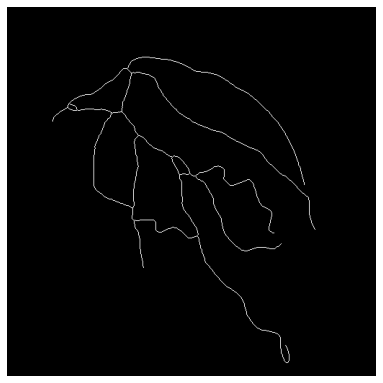

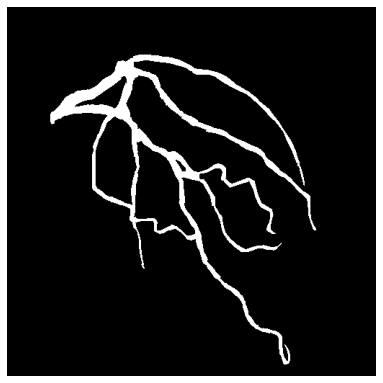

In [5]:
Visualizer.visualize_binary_image([skeleton_image], [1.0])
Visualizer.visualize_binary_image([binary_image], [1.0])

# Step 2 calculate end points and joint points

In [6]:
from data_processing import calculate_end_and_joint_points_by_matlab

joint point (99, 61), degree = 3
joint point (95, 62), degree = 3
joint point (100, 69), degree = 3
joint point (104, 104), degree = 3
joint point (103, 114), degree = 3
joint point (60, 120), degree = 3
joint point (64, 124), degree = 3
joint point (199, 125), degree = 3
joint point (212, 127), degree = 3
joint point (127, 131), degree = 3
joint point (149, 165), degree = 3
joint point (166, 173), degree = 3
joint point (165, 182), degree = 3
joint point (167, 188), degree = 3
joint point (228, 190), degree = 3
end point (113, 46), degree = 1
end point (258, 136), degree = 1
end point (224, 266), degree = 1
end point (236, 273), degree = 1
end point (337, 279), degree = 1
end point (176, 297), degree = 1
end point (220, 307), degree = 1


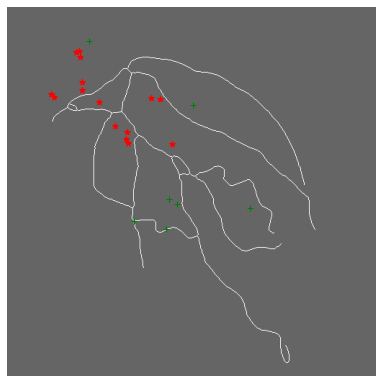

In [7]:
nodes, joint_nodes, end_nodes = calculate_end_and_joint_points_by_matlab(os.path.join(args.save_dir, f"{patient_name}_step1_skeleton.png"), eng)
Visualizer.visualize_artery_tree_with_points(skeleton_image, end_nodes, joint_nodes)
visualizer.visualize_artery_tree_with_points(skeleton_image, end_nodes, joint_nodes, 
                                             os.path.join(args.save_dir, f"{patient_name}_step2_skeleton_with_points.png"))

In [ ]:
# step 3

In [ ]:
# step 2: calculate end points and joint points
    
    # step3:
    # generate vessel objects: generate objects according to extracted artery tree
    # filter vessel objects: remove the vessel segment with the average diameter less than threshold
    original_vessel_objects, graph = graph_generation_by_connectivity(patient_name, nodes, skeleton_image, eng)
    dist_map = diameter_map(os.path.join(data_dir, f'label/{patient_name}.png'), eng)
    filtered_vessel_objects, graph = filter_vessel(original_vessel_objects, graph, nodes, dist_map, patient_name,
                                                   csv_path=spacing_csv_path,
                                                   radius_threshold=radius_threshold,
                                                   centerline_length_threshold=centerline_length_threshold)

    visualizer.visualize_graph(original_vessel_objects, original_image,
                               save_path=os.path.join(save_dir, f"{patient_name}_step3_generated_graph.png"),
                               semantic_mapping=constants.semantic_mapping, assign_label=False)

    visualizer.visualize_graph(filtered_vessel_objects, original_image,
                               save_path=os.path.join(save_dir, f"{patient_name}_step3_filtered_graph.png"),
                               semantic_mapping=constants.semantic_mapping, assign_label=False)

    # step 4: map each centerline to vessel pixels
    vessel_objects, mapped_artery_mask = find_vessel_pixel_in_centerline(filtered_vessel_objects, binary_image)
    visualizer.visualize_binary_image([skeleton_image, mapped_artery_mask], [1.0, 0.5],
                               os.path.join(save_dir, f"{patient_name}_step4_vessel_search.png"))

    # step 5: assign class information to each vessel segments
    semantic_image = generate_semantic_image(semantic_files_path, mapped_artery_mask.shape[0], constants.color_map)
    im = Image.fromarray(semantic_image)
    im.save(os.path.join(save_dir, f"{patient_name}_semantic_image.png"))

    vessel_objects = assign_class(vessel_objects, semantic_image, constants.semantic_mapping)

    # visualizer.visualize_semantic_image(vessel_objects, original_image, constants.semantic_mapping,
    #                                     os.path.join(save_dir, f"{patient_name}_step5_mapped_semantic_label.png"), centerline=False)
    # visualizer.visualize_semantic_image(vessel_objects, original_image, constants.semantic_mapping,
    #                                     os.path.join(save_dir, f"{patient_name}_step5_mapped_semantic_centerline.png"), centerline=True)

    visualizer.visualize_semantic_image2(vessel_objects, original_image, constants.semantic_mapping,
                                        os.path.join(save_dir, f"{patient_name}_step5_mapped_semantic_centerline.png"), centerline=True)
    # visualizer.visualize_semantic_image2(vessel_objects, original_image, constants.semantic_mapping,
                                        # os.path.join(save_dir, f"{patient_name}_step5_mapped_semantic_label.png"), centerline=False)

    visualizer.visualize_graph(vessel_objects,
                               original_image,
                               save_path=os.path.join(save_dir, "{}_step5_generated_graph.png".format(patient_name)),
                               semantic_mapping=constants.semantic_mapping,
                               assign_label=True)

    # save objects
    save_vessel_objs(vessel_objects, file_path=os.path.join(save_dir, "{}.pkl".format(patient_name)))